# PIV 2024

# PB class 4

Images **320.jpg** (grayscale) and **330.jpg** (RGB) are two frames from the same camera mounted on the front of a moving car. They have same **focal length = 1180.0**. The principal point is at the center of the images. The depth map **320_depth.npy** is registered to frame 320.

Your job is to compute the pointcloud corresponding to frame 320 and color it using the RGB values from frame 330. For this, you will have to:

1.   Build the camera matrix and unproject the depth map (**320_depth.npy**) corresponding to the grayscale image (**320.jpg**) to get a grayscale 3D point cloud.
2.   Find 2D matches between the two frames, or use the given the 2D correspondences (**320_330_matches.npy**), to compute a 3D rigid transformation between the cameras.
3.   Color the point cloud from step 1 using the RGB values from **330.jpg**

**Bottom-line:** you should have a grayscale point cloud, a colored point cloud, and the relative pose / transformation between the two frames.


Some additional notes:
- You don't need Open3D but it's useful for visualization.

- MeshLab is a good way of visualizing large point clouds stored as `.ply`

- You should avoid writing loops. Always vectorize - use numpy!

- You can get all the pixel coordinates in an image using [numpy.meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html)

- Useful decompositions, least-squares and inverses in [numpy.linalg](https://numpy.org/doc/2.1/reference/routines.linalg.html)

- Instead of manually querying a depth map or RGB image at specific locations (for example at the location of the matches coordinates), use an interpolation function. See for example [scipy.interpolate.griddata](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html)





In [164]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

### Get the data from the Drive

This will download **320.jpg** (grayscale), **330.jpg** (RGB), the depth map corresponding to frame 320 **320_depth.npy** and a set of point matches between the images stored as **320_330_matches.npy**

In [ ]:
# Get images 320 and 330

! gdown 1IHkv4ri4CwL2A0f4bw2Y1dm7rHftL9Yh --continue
! gdown 1ttU0N4UWj2UedpErslIXjiE1kAUdzI76 --continue
# Get depth map
! gdown 11dBTamoXfRDOt12pCHlLQ7IV6eJ23HWb --continue
# Get matches between images
! gdown 1M1XXHorleaIH1lY6Jbxb5at4wrHv4Cor --continue

'\n! gdown 1IHkv4ri4CwL2A0f4bw2Y1dm7rHftL9Yh --continue\n! gdown 1ttU0N4UWj2UedpErslIXjiE1kAUdzI76 --continue\n# Get depth map\n! gdown 11dBTamoXfRDOt12pCHlLQ7IV6eJ23HWb --continue\n# Get matches between images\n! gdown 1M1XXHorleaIH1lY6Jbxb5at4wrHv4Cor --continue\n\n'

### Load images and depth maps as NumPy arrays

**320.jpg** (grayscale) and **330.jpg** (RGB) are stored as 890 x 1280 x 3 arrays.
The depth map is stored as a 890 x 1280 array with values up to 50m.


Text(0.5, 1.0, 'Depth map of image 1')

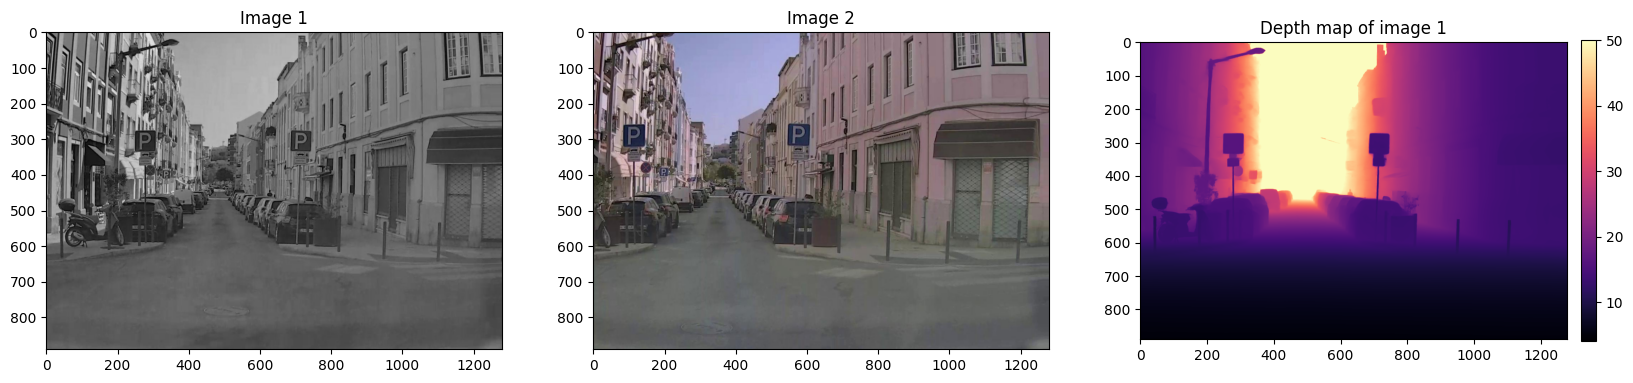

In [166]:
img1 = np.array(Image.open('320.jpg'))
img2 = np.array(Image.open('330.jpg'))
depth1 = np.load('320_depth.npy')

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(img1)
plt.title("Image 1")
plt.subplot(1,3,2)
plt.imshow(img2)
plt.title("Image 2")
plt.subplot(1,3,3)
plt.imshow(depth1, cmap="magma")
plt.colorbar(fraction=0.033, pad=0.03)
plt.title("Depth map of image 1")

### Load and visualize 2D correspondences
Matches are stored as a N x 2 x 2 array (N matches, 2 coordinates x and y and 2 images).

These matches were computed with [CoTracker](https://co-tracker.github.io/). You can also compute your own matches using SIFT, ORB or any other descriptor
 (import OpenCV with `import cv2`).


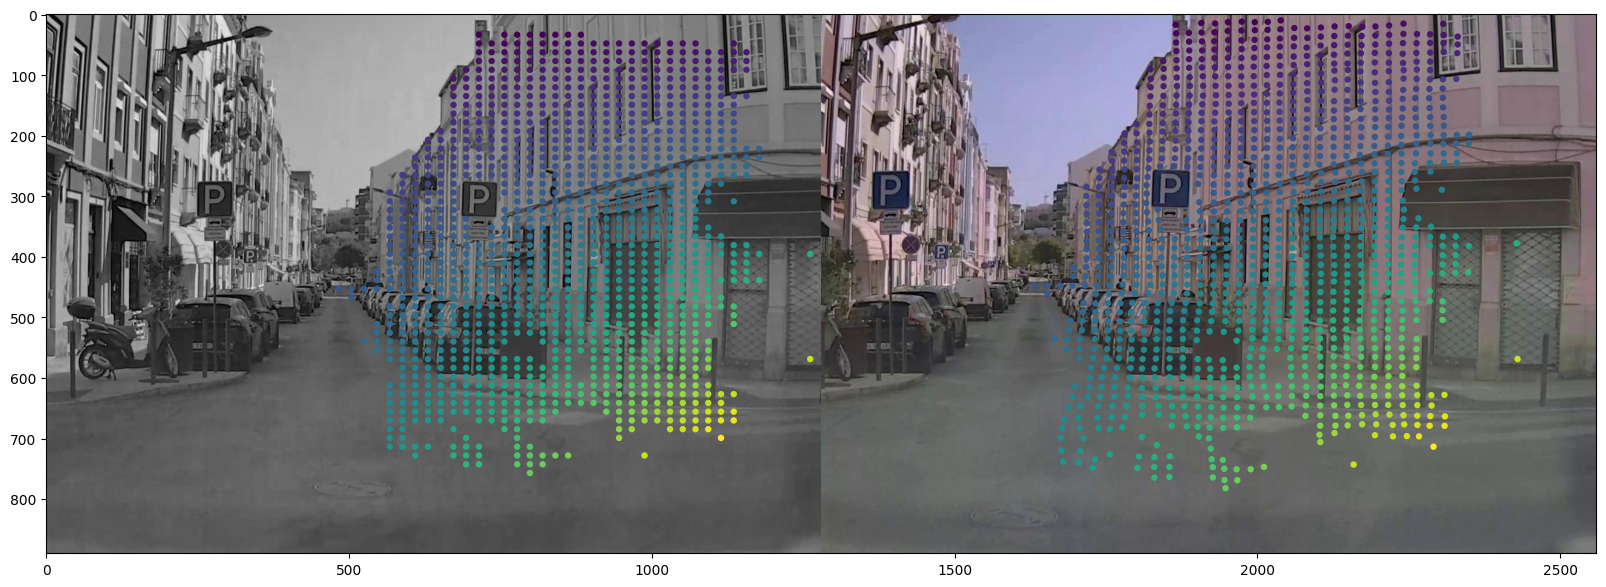

In [167]:
matches = np.load("320_330_matches.npy")

cmap = matplotlib.colormaps['Spectral']

plt.figure(figsize=(20,10))

side_by_side = np.concatenate((img1, img2), axis=1)
plt.imshow(side_by_side)
plt.scatter(matches[:,0,0], matches[:,1,0], 13, c=matches[:,0,0] * matches[:,1,0])
plt.scatter(matches[:,0,1] + img1.shape[1], matches[:,1,1], 13, c=matches[:,0,0] * matches[:,1,0])
plt.show()

# Visualizing your point clouds

You can store your point clouds as .ply files with Open3D (install it first with `pip install open3d`) and use [MeshLab](https://www.meshlab.net/) for visualization.

Below is some code you can use to save your point clouds.


In [168]:
import open3d as o3d

fx = fy = 1180.0
H, W, _ = img1.shape

cx = W / 2
cy = H / 2

K = np.array([[fx,  0, cx],
              [ 0, fy, cy],
              [ 0,  0,  1]])

print("Cam 1 intrisics:\n",K)


z = depth1

u1 = np.arange(W)
v1 = np.arange(H)
u1, v1 = np.meshgrid(u1, v1)

x =  (u1 - cx) * z / fx
y = (v1 - cy) * z / fy


points = np.stack((x, y, z), axis=-1).reshape(-1, 3)
grays = img1.reshape(-1, 3) / 255.0  # normalize grayscale

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(grays)

o3d.io.write_point_cloud("point_cloud_gray.ply", pcd)

Cam 1 intrisics:
 [[1.18e+03 0.00e+00 6.40e+02]
 [0.00e+00 1.18e+03 4.45e+02]
 [0.00e+00 0.00e+00 1.00e+00]]


True

Second camera localisation

P approximation

$ min _p ||Mp-b||^2 => M^T M$ <br>

In [169]:
'''
# CANONICAL SOLUTION Mp = b

b = []
theta = []


z = depth1

matched_u1 = matches[:, 0, 0] #x
matched_v1 = matches[:, 1, 0] #y 

rounded_matched_u1 = np.round(matched_u1).astype(int)
rounded_matched_v1 = np.round(matched_v1).astype(int)
z_match = z[rounded_matched_v1, rounded_matched_u1]

x_match =  (matched_u1 - cx) * z_match / fx
y_match = (matched_v1 - cy) * z_match / fy

matched_points = np.column_stack([x_match, y_match, z_match])

matched_u2 = matches[:, 0, 1] #x
matched_v2 = matches[:, 1, 1] #y 
uv = np.column_stack((matched_u2, matched_v2))

for i,(x,y,z) in enumerate(matched_points):
    xp, yp = uv[i]
    
    theta.append([x, y, z, 1, 0, 0, 0, 0, -x*xp, -y*xp, -z*xp])
    theta.append([0, 0, 0, 0, x, y, z, 1, -x*yp, -y*yp, -z*yp])
    b.append(xp)
    b.append(yp)

'''

'\n# CANONICAL SOLUTION Mp = b\n\nb = []\ntheta = []\n\n\nz = depth1\n\nmatched_u1 = matches[:, 0, 0] #x\nmatched_v1 = matches[:, 1, 0] #y \n\nrounded_matched_u1 = np.round(matched_u1).astype(int)\nrounded_matched_v1 = np.round(matched_v1).astype(int)\nz_match = z[rounded_matched_v1, rounded_matched_u1]\n\nx_match =  (matched_u1 - cx) * z_match / fx\ny_match = (matched_v1 - cy) * z_match / fy\n\nmatched_points = np.column_stack([x_match, y_match, z_match])\n\nmatched_u2 = matches[:, 0, 1] #x\nmatched_v2 = matches[:, 1, 1] #y \nuv = np.column_stack((matched_u2, matched_v2))\n\nfor i,(x,y,z) in enumerate(matched_points):\n    xp, yp = uv[i]\n\n    theta.append([x, y, z, 1, 0, 0, 0, 0, -x*xp, -y*xp, -z*xp])\n    theta.append([0, 0, 0, 0, x, y, z, 1, -x*yp, -y*yp, -z*yp])\n    b.append(xp)\n    b.append(yp)\n\n'

In [170]:
# BETTER SOLUTION Mp=0

M = []

z = depth1

matched_u1 = matches[:, 0, 0] #x
matched_v1 = matches[:, 1, 0] #y 

rounded_matched_u1 = np.round(matched_u1).astype(int)
rounded_matched_v1 = np.round(matched_v1).astype(int)
z_match = z[rounded_matched_v1, rounded_matched_u1]

x_match =  (matched_u1 - cx) * z_match / fx
y_match = (matched_v1 - cy) * z_match / fy

matched_points = np.column_stack([x_match, y_match, z_match])

matched_u2 = matches[:, 0, 1] #x
matched_v2 = matches[:, 1, 1] #y 
uv = np.column_stack((matched_u2, matched_v2))

for i,(x,y,z) in enumerate(matched_points):
    xp, yp = uv[i]
    # XYZ1*p1 -   0*p2 - xp*XYZ1*p3 = 0
    M.append([x, y, z, 1, 0, 0, 0, 0, -x*xp, -y*xp, -z*xp, -xp])
    #   0*p1 - XYZ1*p2 - yp*XYZ1*p3 = 0
    M.append([0, 0, 0, 0, x, y, z, 1, -x*yp, -y*yp, -z*yp, -yp])

M = np.array(M)

Solve for P

$ min _p ||Mp||^2 = p^TM^TMp, ||p|| = 1$ <br>
$M^TMp=\lambda p$<br>
SVD: $M = U \Sigma V^T$ <br>
$M^TM = V \Sigma^2 V^T$

beacuse $||M v_i|| = \sigma _i$ we minimise $\sigma$, so we take the last column 

In [171]:
_, _, V = np.linalg.svd(M)
# The solution is the last row of V^T (smallest singular value)
pv = V[-1]
P = pv.reshape(3,4)

print("P matrix:\n", P)

P matrix:
 [[ 6.03740712e-01 -8.78235996e-04  2.62699017e-01 -3.33631570e-01]
 [ 6.24942505e-04  6.00907696e-01  2.23941121e-01 -2.09606855e-01]
 [ 4.95678386e-06  3.40148948e-06  5.11471262e-04 -4.60300596e-04]]


## Solution A: K unknown<br><br>
$P_0 = KR$,  $~~q = KT$ <br>
$(P_0)^{-1} = Q'R'$, <br>
$R = Q'^{-1}$, $~~ T = K^{-1}q$, $~~ K = R'^{-1}$

In [172]:
P0 = P[:, :3]
q = P[:,3]

iR, iK= np.linalg.qr(np.linalg.inv(P0))

R = np.linalg.inv(iR)
Ke = np.linalg.inv(iK)
T = iK @ q

print("R: \n", R)
print("K: \n", Ke)
print("T: \n", T)

R: 
 [[-0.99994955 -0.0025779   0.00970788]
 [ 0.00264228 -0.99997457  0.00662463]
 [ 0.00969056  0.00664994  0.99993093]]
K: 
 [[-6.01157741e-01  4.21375065e-03  2.68525617e-01]
 [-0.00000000e+00 -5.99407235e-01  2.27927712e-01]
 [ 0.00000000e+00  0.00000000e+00  5.11506590e-04]]
T: 
 [ 0.15306993  0.0075017  -0.89989182]


Normalisation

In [173]:
# check if R is a rotation matrix in correct form (det(R) == 1),
# if negative would have to mirror axis by flipping signs in a row

print("Det R:\n", round(np.linalg.det(R), 5))

#normalisation
last = Ke[2,2]
Ke = Ke / last
print("normalised K:\n", Ke)

Det R:
 1.0
normalised K:
 [[-1.17526881e+03  8.23792056e+00  5.24970005e+02]
 [-0.00000000e+00 -1.17184655e+03  4.45600733e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


The given matrix has skew, but is neglectable as it is 3 orders of magnitude smaller.<br>
as K has negative $f_x$, $f_y$ we have to modify it

$P_0 = K R => P_0 = K F F^{-1} R$,  knowing that $F F^{-1} = I$

In [174]:
F = np.diag([-1, -1, 1]) # columnwise edit - we flip the sign of columns 1 and 2
Ke = Ke @ F

# symmetric operation on R
R = np.linalg.inv(F) @ R


# changes check has to have the same result (reverting the K normalisation)
print("is correct:\n", np.all(np.isclose(P0, Ke*last @ R)))
print("R determinant:\n", round(np.linalg.det(R), 5))

print("\nrotated R:\n",R)
print("modified K:\n", Ke)

#error comparation on the scale of biggest variable
print("\nEstimated vs given K (scaled): \n", (K-Ke) / K.max())

is correct:
 True
R determinant:
 1.0

rotated R:
 [[ 0.99994955  0.0025779  -0.00970788]
 [-0.00264228  0.99997457 -0.00662463]
 [ 0.00969056  0.00664994  0.99993093]]
modified K:
 [[ 1.17526881e+03 -8.23792056e+00  5.24970005e+02]
 [ 0.00000000e+00  1.17184655e+03  4.45600733e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Estimated vs given K (scaled): 
 [[ 0.00400948  0.00698129  0.09748305]
 [ 0.          0.0069097  -0.0005091 ]
 [ 0.          0.          0.        ]]


## Solution B: K is known <br><br>
$P_0 = KR$,  $~~q = KT$ <br>
R&#773;$ = K^{-1}P_0$, $~~T = K^{-1}q$ <br>
it isn't a rotation matrix, this will be approximated by <br>
$U, \Sigma, V^T = SVD($ R&#773;$)$ <br>
$R =  U V^T$

In [175]:
T_solutionB =  np.linalg.inv(K) @ q
Rdash =  np.linalg.inv(K) @ P0 

print("R dash column norms: \n",np.linalg.norm(Rdash, axis=0))

#Rdash = Rdash/ np.linalg.norm(Rdash, axis=0)

# rotation matrix approximation by SVD
U, _, Vt = np.linalg.svd(Rdash)
R_solutionB  = U @ Vt

print("determinant of new R:\n",round(np.linalg.det(R_solutionB),5))

print("\nR: \n", R_solutionB)
print("K: \n", K)
print("T: \n", T_solutionB)

R dash column norms: 
 [0.00050898 0.00050798 0.00051441]
determinant of new R:
 1.0

R: 
 [[ 9.98289541e-01 -1.24886072e-03 -5.84502590e-02]
 [ 8.71050667e-04  9.99978568e-01 -6.48881953e-03]
 [ 5.84571099e-02  6.42680753e-03  9.98269233e-01]]
K: 
 [[1.18e+03 0.00e+00 6.40e+02]
 [0.00e+00 1.18e+03 4.45e+02]
 [0.00e+00 0.00e+00 1.00e+00]]
T: 
 [-3.30840582e-05 -4.04499150e-06 -4.60300596e-04]


In [181]:
#Comparision of solution A and B results

print("\nR diffrence: \n", R-R_solutionB)
print("T difference: \n", T - T_solutionB)


R diffrence: 
 [[ 1.66001349e-03  3.82676569e-03  4.87423772e-02]
 [-3.51333445e-03 -4.00200529e-06 -1.35806315e-04]
 [-4.87665527e-02  2.23135107e-04  1.66169985e-03]]
T difference: 
 [ 0.15310302  0.00750574 -0.89943152]


## Coloring the point cloud (based on solution A results)

In [177]:
colors = []

fx2, _, cx2, _, fy2, cy2, _, _, _ = Ke.reshape(-1)

for X in points:
    X2 = R @ X + T
    x2, y2, z2 = X2

    if z2 < 0: # behind camera check
        colors.append([0,0,0])
        continue

    #p = Ke @ np.array([x2/z2, y2/z2, 1])
    #u,v = p[0]/p[2], p[1]/p[2]
    u = fx2 * (x2/z2) + cx2
    v = fy2 * (y2/z2) + cy2



    if u<0 or u>=W or v<0 or v >H: #out of bounds check
        colors.append(np.array([255,192,203])/255.0)
        continue

    colors.append(img2[int(v), int(u)]/255.0)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)

o3d.io.write_point_cloud("point_cloud_color.ply", pcd)

True


# visualisations

In [178]:
import open3d as o3d
pcd = o3d.io.read_point_cloud("point_cloud.ply")
o3d.visualization.draw_geometries([pcd])

In [179]:
import open3d as o3d
pcd = o3d.io.read_point_cloud("point_cloud_color.ply")
o3d.visualization.draw_geometries([pcd])

### optional: frustum image

In [180]:
def make_frustum(K, R, t, w, h, depth=1.0, color=[1,0,0]):
    Kinv = np.linalg.inv(K)

    # 4 pixel corners
    px = np.array([
        [  0,  0,  1],
        [w-1,  0,  1],
        [w-1, h-1, 1],
        [  0, h-1, 1] 
    ]).T  # (3,4)

    # backproject into camera coords
    cam = (Kinv @ px) * depth

    # world
    corners = (R @ cam) + t.reshape(3,1)

    # camera center
    C = t.reshape(3)

    pts = np.vstack([C, corners.T])

    # frustum lines
    lines = [
        [0,1],[0,2],[0,3],[0,4], # center to corner
        [1,2],[2,3],[3,4],[4,1] # square edges
    ]
    line_colors = [color]*len(lines)

    ls = o3d.geometry.LineSet()
    ls.points = o3d.utility.Vector3dVector(pts)
    ls.lines  = o3d.utility.Vector2iVector(lines)
    ls.colors = o3d.utility.Vector3dVector(line_colors)
    return ls


def visualize(pcd_path, K1, K2, R2, t2, img_w=1280, img_h=720, depth=1.5):
    # point cloud
    pcd = o3d.io.read_point_cloud(pcd_path)

    # cam 1
    R1 = np.eye(3)
    t1 = np.zeros(3)
    fr1 = make_frustum(K1, R1, t1, img_w, img_h, depth, [1,0,0])

    # cam 2
    fr2 = make_frustum(K2, R2, t2, img_w, img_h, depth, [0,1,0])

    o3d.visualization.draw_geometries([pcd, fr1, fr2])

visualize('point_cloud_color.ply', K, Ke, R, T)